## Implementation of the fast gradient sign method

Based on the paper: <i>Explaining and Harnessing Adversarial Examples<i>.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib import image as plt_image
import numpy as np
import requests
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
model = tf.keras.applications.vgg16.VGG16(include_top=True,weights="imagenet",classifier_activation="softmax")

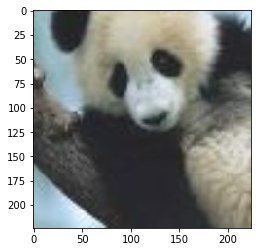

(1, 224, 224, 3)


In [3]:
image = plt_image.imread("../data/images/panda.jpg")
plt.imshow(image)
plt.show()
image = image.astype("float32")
image = np.expand_dims(image,axis=0)
print(image.shape)

In [4]:
def get_predictions(model_output,n=5):
    """ takes in model output softmax and returns top n predictions
    """
    label_dict = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').json()
    model_output = np.squeeze(model_output.numpy())
    model_predictions = {}
    for i in range(1,n+1):
        pred_i = np.argmax(model_output)
        pred_prob = model_output[pred_i]
        pred_name = label_dict[str(pred_i)][1]
        model_output[pred_i] = -np.inf
        model_predictions[i]=[pred_name,pred_prob,pred_i]
    return model_predictions

In [5]:
out_probs = model(image)
print(get_predictions(out_probs))

{1: ['indri', 0.2604218, 384], 2: ['giant_panda', 0.17264535, 388], 3: ['kuvasz', 0.083818585, 222], 4: ['Madagascar_cat', 0.0781454, 383], 5: ['gibbon', 0.04065567, 368]}


In [6]:
def loss_func(y_true,y_pred):
    """ standard loss
    """
    loss = SparseCategoricalCrossentropy()(y_true,y_pred)
    return loss

In [7]:
# getting gradients for generating adversarial image
input_x = tf.convert_to_tensor(image)
suggested_y = np.ones((1,))*384.0

with tf.GradientTape() as tape:
    tape.watch(input_x)
    model_pred = model(input_x)
    loss = loss_func(suggested_y,model_pred)
gradients = tape.gradient(loss,input_x)

In [8]:
gradients[0,:4,:4,:]

<tf.Tensor: shape=(4, 4, 3), dtype=float32, numpy=
array([[[-2.1490241e-06,  2.4456289e-05,  1.3973462e-05],
        [ 3.6659356e-05,  1.0855113e-04,  7.4989082e-05],
        [ 7.7332115e-05,  1.8010796e-04,  1.2985655e-04],
        [ 7.4989955e-05,  2.1344218e-04,  1.3739125e-04]],

       [[-2.9243594e-05,  7.9374395e-06, -2.6209227e-06],
        [-1.9085348e-05,  7.1224596e-05,  3.7066486e-05],
        [-7.0912240e-05,  4.4195829e-05, -4.3717155e-06],
        [-5.3501455e-05,  1.1053322e-04,  3.1197942e-05]],

       [[-2.8643994e-05,  6.5313225e-06,  5.2460896e-06],
        [-3.8281509e-05,  2.3329578e-05,  1.9024172e-05],
        [-1.4746655e-04, -9.3551003e-05, -9.1387978e-05],
        [-8.7673485e-05, -9.4031275e-06, -1.6322796e-05]],

       [[-6.9709218e-05, -3.4266894e-05, -4.1566942e-05],
        [-9.2643299e-05, -3.1277199e-05, -4.1065618e-05],
        [-1.8185450e-04, -1.3153227e-04, -1.2302624e-04],
        [-1.1897793e-04, -8.1017446e-05, -5.0203475e-05]]], dtype=float32

In [9]:
gradients.shape

TensorShape([1, 224, 224, 3])

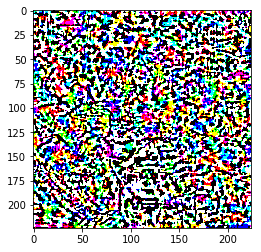

In [10]:
# visualizing the noise
g = tf.sign(gradients)
plt.imshow(g[0]*0.5+0.5)
plt.show()

In [11]:
# generating the adversarial image input
gradients = tf.sign(gradients).numpy()
e = 0.1
n=e*gradients
new_input = input_x+n
new_model_out = model(new_input)
print(get_predictions(new_model_out))

{1: ['kuvasz', 0.2426392, 222], 2: ['Great_Pyrenees', 0.14234371, 257], 3: ['giant_panda', 0.09083113, 388], 4: ['toy_poodle', 0.043804973, 265], 5: ['Saint_Bernard', 0.034881897, 247]}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


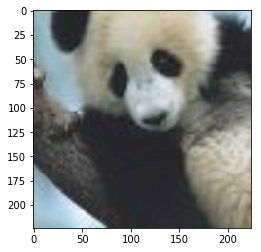

In [12]:
plt.imshow(new_input[0]/255)
plt.show()

In [13]:
# example in which the update to the original image is large, thus you can tell it has been altered
e = 10.1
n=e*gradients
new_input = input_x+n
new_model_out = model(new_input)
print(get_predictions(new_model_out))

{1: ['Sealyham_terrier', 0.5273364, 190], 2: ['Labrador_retriever', 0.07012061, 208], 3: ['dalmatian', 0.04581886, 251], 4: ['clumber', 0.042317726, 216], 5: ['kuvasz', 0.037603904, 222]}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


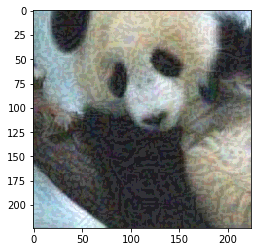

In [14]:
plt.imshow(new_input[0]/255)
plt.show()

### An occasional issue in applying this method results from the softmax saturating

The saturation results in the gradient being unable to propogate back to the input, meaning that the update will be all zeros and thus be useless. One method to get around this is to calculate the gradients with a copied model which utilizes softmax with a relatively large temperature to smooth out the output distribution over the labels y. Below is an example of utilizing this approach.

In [15]:
mnist = tf.keras.datasets.mnist.load_data()
x_train,y_train,x_test,y_test = mnist[0][0],mnist[0][1],mnist[1][0],mnist[1][1]
x_train,y_train = x_train.astype("float32"),y_train.astype("int32")
x_test,y_test = x_test.astype("float32"),y_test.astype("int32")
x_train,y_train = x_train[y_train <= 4],y_train[y_train <= 4]
x_test,y_test = x_test[y_test <= 4],y_test[y_test <= 4]
x_train,y_train = np.expand_dims(x_train,axis=-1),np.expand_dims(y_train,axis=-1)
x_test,y_test = np.expand_dims(x_test,axis=-1),np.expand_dims(y_test,axis=-1)
x,y = x_train[:30500],y_train[:30500]
print(x.shape,y.shape,x_test.shape,y_test.shape)

(30500, 28, 28, 1) (30500, 1) (5139, 28, 28, 1) (5139, 1)


In [16]:
def compile_model(optimizer=Adam(lr=0.001)):
    """ model implementation
    """
    x = Input(shape=(28,28))
    x_f = Flatten()(x)
    h = Dense(128,activation='relu')(x_f)
    h = Dense(5,activation=None)(h)
    out = Activation('softmax')(h)
    
    model = Model(inputs=x,outputs=out)
    model.compile(loss=loss_func,optimizer=optimizer)
    return model

In [17]:
model = compile_model()

In [18]:
n_epochs=5
batch_size=100
for epoch_i in range(n_epochs):
    losses = []
    for i in range(0,len(x),batch_size):
        x_train_subset = x[i:i+batch_size]
        y_train_subset = y[i:i+batch_size]
        batch_loss = model.train_on_batch(x_train_subset,y_train_subset)
        losses.append(float(batch_loss))
        break
    print("Epoch {}: {}".format(epoch_i+1,sum(losses)/len(losses)))

Epoch 1: 86.90263366699219
Epoch 2: 35.482479095458984
Epoch 3: 11.868574142456055
Epoch 4: 3.987635612487793
Epoch 5: 2.048457384109497


In [19]:
# removing the softmax component, so the model returns logits
logits_model = Model(inputs=model.input,outputs=model.layers[-2].output)

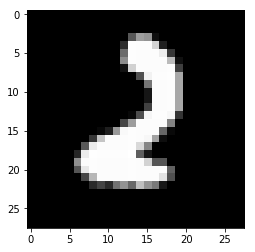

In [20]:
# visualizing the example to be altered
i=1501
plt.imshow(np.squeeze(x_test[i]),cmap='gray')
plt.show()

In [21]:
# base model softmax output for this example
print(model(np.expand_dims(x_test[i],axis=0)))

tf.Tensor([[0.00000e+00 4.39308e-29 1.00000e+00 0.00000e+00 0.00000e+00]], shape=(1, 5), dtype=float32)


In [22]:
suggested_y = np.ones((1,)).astype("int32")*2 # actual label for this example

input_x = x_test[i]
input_x = np.expand_dims(np.squeeze(input_x),axis=0)
input_x = tf.convert_to_tensor(input_x)
print(input_x.shape)

(1, 28, 28)


In [23]:
# using model with standard softmax
with tf.GradientTape() as tape:
    tape.watch(input_x)
    model_pred = logits_model(input_x)
    model_pred = Activation('softmax')(model_pred)
    loss = loss_func(suggested_y,model_pred)

gradients = tape.gradient(loss,input_x)
print(float(loss))

4.768370445162873e-07


In [24]:
gradients[0,:8,:8]

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [25]:
# using model with softmax w/ temperature
with tf.GradientTape() as tape:
    tape.watch(input_x)
    model_pred = logits_model(input_x)
    model_pred = Activation('softmax')(model_pred/20.0) # temperature=20
    loss = loss_func(suggested_y,model_pred)

gradients = tape.gradient(loss,input_x)
print(float(loss))

0.03749581426382065


In [26]:
gradients[0,:8,:8]

<tf.Tensor: shape=(8, 8), dtype=float32, numpy=
array([[ 1.02299178e-04, -9.52925620e-05, -2.03919568e-04,
        -5.33247221e-05, -8.36211620e-05,  1.91040672e-04,
         3.38001482e-05, -1.81050578e-04],
       [-1.07862579e-05, -1.28938758e-04,  1.36181643e-05,
        -2.71933859e-05,  1.20962985e-04,  3.07790178e-05,
        -1.21516030e-04, -1.95205386e-04],
       [ 5.40954497e-05,  4.76644782e-05, -5.13213854e-05,
         1.01153470e-04,  9.73342685e-05,  2.39247893e-04,
         2.30652236e-04,  5.09941310e-06],
       [ 2.70847704e-05, -9.36018332e-05, -2.10330822e-04,
        -1.37902636e-04, -1.87894097e-04, -5.53187201e-05,
        -1.09934335e-04, -9.12456817e-05],
       [-7.71586201e-06, -7.89015758e-06,  8.00020644e-06,
         8.29234050e-05,  1.97355053e-04, -3.33241987e-05,
         2.54532515e-05,  7.19704403e-05],
       [ 6.39886566e-05,  8.58639251e-05, -1.35402501e-04,
        -7.95441738e-05, -2.29069337e-06,  1.04396226e-04,
        -2.41901325e-05,  2.4

In [27]:
# output utilizing softmax with temperature
print(Activation('softmax')(logits_model(np.expand_dims(x_test[i],axis=0)).numpy()/20.0))

tf.Tensor([[8.0816960e-07 3.6800522e-02 9.6319866e-01 3.0372171e-08 1.4247448e-09]], shape=(1, 5), dtype=float32)


In [28]:
gradients = tf.sign(gradients.numpy())
e = 7.1
n=e*gradients
new_input = np.expand_dims(np.squeeze(x_test[i]),axis=0)+n
new_input.shape

TensorShape([1, 28, 28])

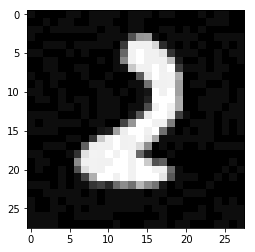

In [29]:
plt.imshow(np.squeeze(new_input),cmap='gray') # visualizing adversarial example
plt.show()

In [30]:
model_pred = model(new_input)
model_pred

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 1., 0., 0., 0.]], dtype=float32)>